# CS188 Project 2 - Binary Classification Comparative Methods

For this project we're going to attempt a binary classification of a dataset using multiple methods and compare results. 

Our goals for this project will be to introduce you to several of the most common classification techniques, how to perform them and tweek parameters to optimize outcomes, how to produce and interpret results, and compare performance. You will be asked to analyze your findings and provide explanations for observed performance. 

Specifically you will be asked to classify whether a <b>patient is suffering from heart disease</b> based on a host of potential medical factors.

<b><u>DEFINITIONS</u></b>


<b> Binary Classification:</b>
In this case a complex dataset has an added 'target' label with one of two options. Your learning algorithm will try to assign one of these labels to the data.

<b> Supervised Learning:</b>
This data is fully supervised, which means it's been fully labeled and we can trust the veracity of the labeling.

## Background: The Dataset 

For this exercise we will be using a subset of the UCI Heart Disease dataset, leveraging the fourteen most commonly used attributes. All identifying information about the patient has been scrubbed. 

The dataset includes 14 columns. The information provided by each column is as follows:
<ul>
    <li><b>age:</b> Age in years</li>
    <li><b>sex:</b> (1 = male; 0 = female)</li>
    <li><b>cp:</b> Chest pain type (0 = asymptomatic; 1 = atypical angina; 2 = non-anginal pain; 3 = typical angina)</li>
    <li><b>trestbps:</b> Resting blood pressure (in mm Hg on admission to the hospital)</li>
    <li><b>cholserum:</b> Cholestoral in mg/dl</li>
    <li><b>fbs</b> Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)</li>
    <li><b>restecg:</b> Resting electrocardiographic results (0= showing probable or definite left ventricular hypertrophy by Estes' criteria; 1 = normal; 2 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV))</li>
    <li><b>thalach:</b> Maximum heart rate achieved</li>
    <li><b>exang:</b> Exercise induced angina (1 = yes; 0 = no)</li>
    <li><b>oldpeakST:</b> Depression induced by exercise relative to rest</li>
    <li><b>slope:</b> The slope of the peak exercise ST segment (0 = downsloping; 1 = flat; 2 = upsloping)</li>
    <li><b>ca:</b> Number of major vessels (0-3) colored by flourosopy</li>
    <li><b>thal:</b> 1 = normal; 2 = fixed defect; 7 = reversable defect</li>
    <li><b><u>Sick:</u></b> Indicates the presence of Heart disease (True = Disease; False = No disease)</li>
</ul>
    


## Loading Essentials and Helper Functions 

In [746]:
#Here are a set of libraries we imported to complete this assignment. 
#Feel free to use these or equivalent libraries for your implementation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # this is used for the plot the graph 
import os
import seaborn as sns # used for plot interactive graph.
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import sklearn.metrics.cluster as smc
from sklearn.model_selection import KFold


from matplotlib import pyplot
import itertools

%matplotlib inline
import random 
  
random.seed(42) 

In [747]:
# Helper function allowing you to export a graph
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [748]:
# Helper function that allows you to draw nicely formatted confusion matrices
def draw_confusion_matrix(y, yhat, classes):
    '''
        Draws a confusion matrix for the given target and predictions
        Adapted from scikit-learn and discussion example.
    '''
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)
    
    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

## [20 Points] Part 1. Load the Data and Analyze

Let's first load our dataset so we'll be able to work with it. (correct the relative path if your notebook is in a different directory than the csv file.)

In [749]:
DATASET_PATH = "heartdisease.csv"
heartdisease = pd.read_csv(DATASET_PATH)

### Question 1.1 Now that our data is loaded, let's take a closer look at the dataset we're working with. Use the head method to display some of the rows so we can visualize the types of data fields we'll be working with, then use the describe method, along with any additional methods you'd like to call to better help you understand what you're working with and what issues you might face. 

In [750]:
heartdisease.head().iloc[:, :13]  # first 13 columns

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2


In [751]:
heartdisease.describe().iloc[:, :6] # first 6 columns

,age,sex,cp,trestbps,chol,fbs
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000


In [752]:
heartdisease.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
sick        303 non-null bool
dtypes: bool(1), float64(1), int64(12)
memory usage: 31.1 KB


### Question 1.2 Discuss your data preprocessing strategy. Are their any datafield types that are problemmatic and why? Will there be any null values you will have to impute and how do you intend to do so? Finally, for your numeric and categorical features, what if any, additional preprocessing steps will you take on those data elements?

To preprocess the data, we need to first remove labels from features. Then, we also need to differentiate categorical and numeric features in order to process each type separately. We will normalize numeric features and one-hot encode categorical features that do not have obvious ordial meanings. In the end, separate the dataset into training and test sets. The sick variable is of type boolean, while others are all of type int or float; therefore, we will need to fix this field by converting booleans to 0 and 1. There will be not be any null values that I need to impute. <br><br>
Numeric features:
<ul>
    <li><b>age:</b> Age in years</li>
    <li><b>trestbps:</b> Resting blood pressure (in mm Hg on admission to the hospital)</li>
    <li><b>cholserum:</b> Cholestoral in mg/dl</li>
    <li><b>thalach:</b> Maximum heart rate achieved</li> 
    <li><b>oldpeakST:</b> Depression induced by exercise relative to rest</li>
    <li><b>ca:</b> Number of major vessels (0-3) colored by flourosopy</li>
</ul>
Categorical features:
<ul>
    <li>One Hot Encode: </li>
    <ul>
        <li><b>sex:</b> (1 = male; 0 = female)</li>
        <li><b>cp:</b> Chest pain type (0 = asymptomatic; 1 = atypical angina; 2 = non-anginal pain; 3 = typical angina)</li>
        <li><b>restecg:</b> Resting electrocardiographic results (0= showing probable or definite left ventricular hypertrophy by Estes' criteria; 1 = normal; 2 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV))</li>
        <li><b>slope:</b> The slope of the peak exercise ST segment (0 = downsloping; 1 = flat; 2 = upsloping)</li>
        <li><b>thal:</b> 1 = normal; 2 = fixed defect; 7 = reversable defect</li>
    </ul>
    <li>No need to one hot encode: </li>
    <ul>
        <li><b>fbs</b> Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
    </li>
        <li><b>exang:</b> Exercise induced angina (1 = yes; 0 = no)</li>
    </ul>
    <li><b>sick:</b> Indicates the presence of Heart disease (True = Disease; False = No disease)</li>
</ul>

### Question 1.3  Before we begin our analysis we need to fix the field(s) that will be problematic. Specifically convert our boolean sick variable into a binary numeric target variable (values of either '0' or '1'), and then drop the original sick datafield from the dataframe.

In [753]:
sick = heartdisease["sick"].copy()
sick_list = []
for i in sick:
    if i is False:
        sick_list.append(0)
    else:
        sick_list.append(1)
heartdisease["sick"] = sick_list
heartdisease.head().iloc[:, :13]  # first 13 columns

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2


### Question 1.4 Now that we have a feel for the data-types for each of the variables, plot histograms of each field and attempt to ascertain how each variable performs (is it a binary, or limited selection, or does it follow a gradient? (Note: No need to describe each variable, but pick out a few you wish to highlight)

### Numeric features

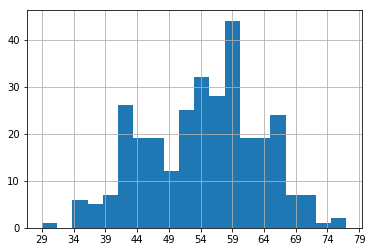

In [754]:
heartdisease["age"].hist(bins=20)
plt.xticks(np.arange(min(heartdisease["age"]), max(heartdisease["age"])+5, 5))
plt.show()

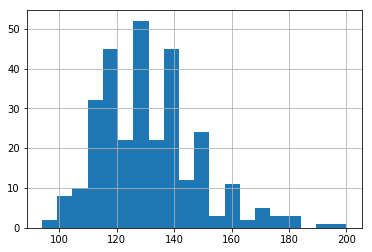

In [755]:
heartdisease["trestbps"].hist(bins=20)
plt.show()

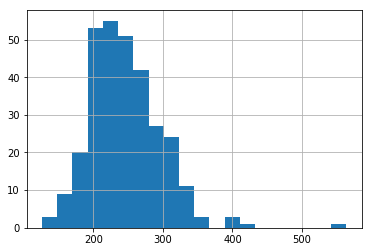

In [756]:
heartdisease["chol"].hist(bins=20)
plt.show()

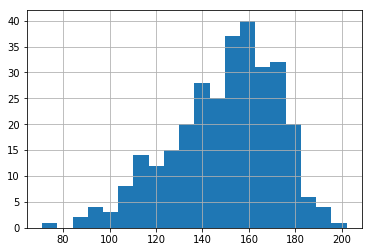

In [757]:
heartdisease["thalach"].hist(bins=20)
plt.show()

The maximum heart rate achieved is a left-skewed distribution with most of its values concentrated at the range from 150-170 bps. 

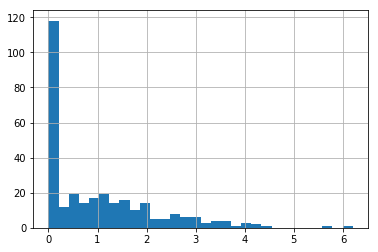

In [758]:
heartdisease["oldpeak"].hist(bins=30)
plt.show()

Depression induced by exercise relative to rest is a numeric feature that is highly right-skewed.

### Categorical Features

Give both histogram and bar plots.

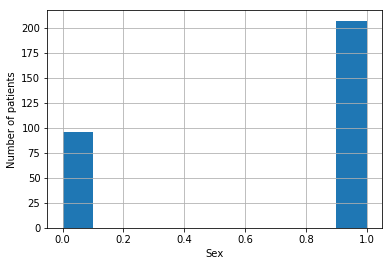

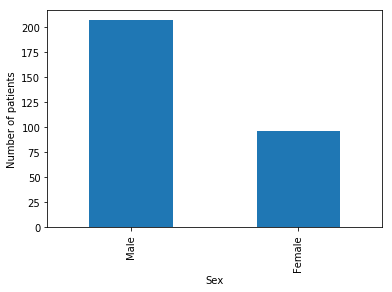

In [759]:
heartdisease["sex"].hist()
plt.ylabel("Number of patients")
plt.xlabel("Sex")
plt.show()

heartdisease["sex"].value_counts().plot.bar()
plt.ylabel("Number of patients")
plt.xlabel("Sex")
plt.xticks([0,1], ["Male", "Female"])
plt.show()

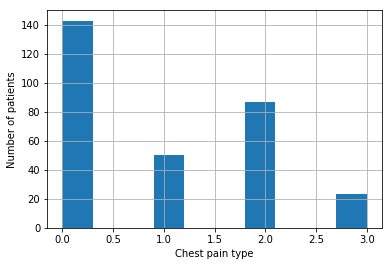

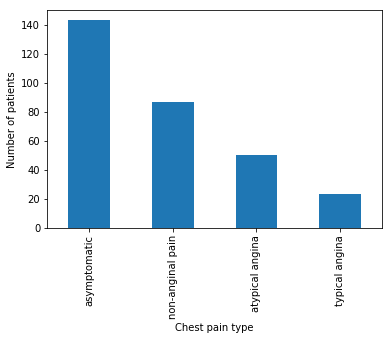

0    143
2     87
1     50
3     23
Name: cp, dtype: int64

In [760]:
heartdisease["cp"].hist()
plt.ylabel("Number of patients")
plt.xlabel("Chest pain type")
plt.show()

heartdisease["cp"].value_counts().plot.bar()
plt.ylabel("Number of patients")
plt.xlabel("Chest pain type")
plt.xticks([0,2,1,3], ["asymptomatic", "atypical angina", "non-anginal pain", "typical angina"]) 
#0 = asymptomatic; 1 = atypical angina; 2 = non-anginal pain; 3 = typical angina
plt.show()
heartdisease["cp"].value_counts()

The values of chest pain type has a limited selection from 0:asymptomatic, 1:atypical angina, 2:non-anginal pain, and 3:typical angina. Most patients are asymptomatic. There are more patients who feel non-anginal pain than those who feel atypical angina. There are least patients who feel typical angina. 

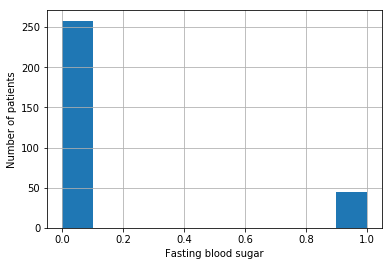

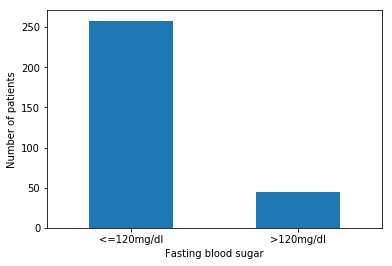

0    258
1     45
Name: fbs, dtype: int64

In [761]:
heartdisease["fbs"].hist()
plt.ylabel("Number of patients")
plt.xlabel("Fasting blood sugar")
plt.show()

heartdisease["fbs"].value_counts().plot.bar()
plt.ylabel("Number of patients")
plt.xlabel("Fasting blood sugar")
plt.xticks([0,1], ["<=120mg/dl", ">120mg/dl"], rotation='horizontal')
#Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
plt.show()
heartdisease["fbs"].value_counts()

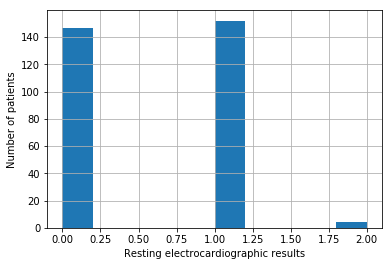

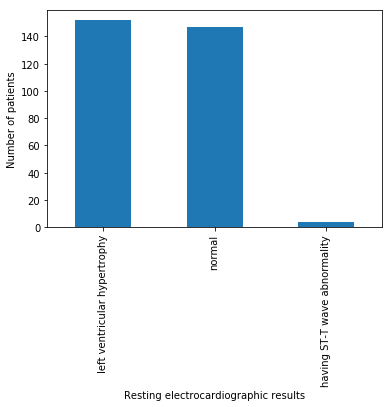

1    152
0    147
2      4
Name: restecg, dtype: int64

In [762]:
heartdisease["restecg"].hist()
plt.ylabel("Number of patients")
plt.xlabel("Resting electrocardiographic results")
plt.show()

heartdisease["restecg"].value_counts().plot.bar()
plt.ylabel("Number of patients")
plt.xlabel("Resting electrocardiographic results")
plt.xticks([0,1,2], ["left ventricular hypertrophy", "normal", "having ST-T wave abnormality"])
#0= showing probable or definite left ventricular hypertrophy by Estes' criteria; 1 = normal; 2 = having ST-T wave abnormality 
plt.show()
heartdisease["restecg"].value_counts()

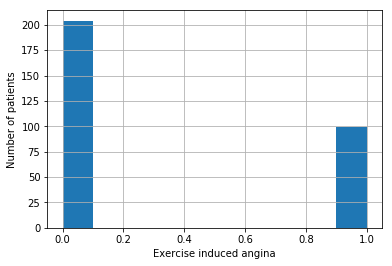

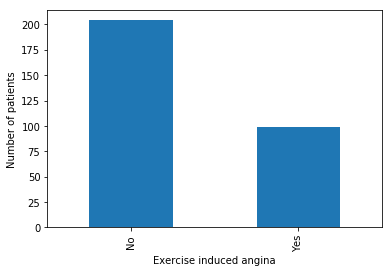

0    204
1     99
Name: exang, dtype: int64

In [763]:
heartdisease["exang"].hist()
plt.ylabel("Number of patients")
plt.xlabel("Exercise induced angina")
plt.show()
heartdisease["exang"].value_counts().plot.bar()
plt.ylabel("Number of patients")
plt.xlabel("Exercise induced angina")
plt.xticks([0,1], ["No", "Yes"])
# Exercise induced angina (1 = yes; 0 = no)
plt.show()
heartdisease["exang"].value_counts()

The execise induced angina is a binary variable. There are almost 1/3 of the diseases related to exercising.

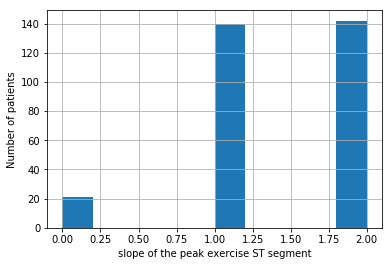

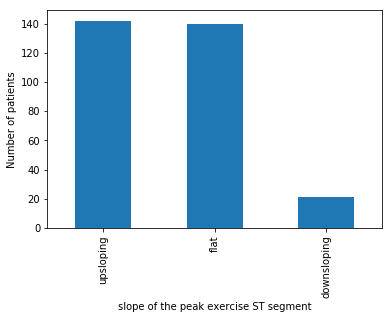

2    142
1    140
0     21
Name: slope, dtype: int64

In [764]:
heartdisease["slope"].hist()
plt.ylabel("Number of patients")
plt.xlabel("slope of the peak exercise ST segment")
plt.show()

heartdisease["slope"].value_counts().plot.bar()
plt.ylabel("Number of patients")
plt.xlabel("slope of the peak exercise ST segment")
plt.xticks([2,1,0], ["downsloping", "flat", "upsloping"])
# slope of the peak exercise ST segment (0 = downsloping; 1 = flat; 2 = upsloping)
plt.show()
heartdisease["slope"].value_counts()

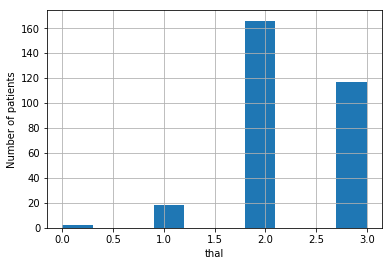

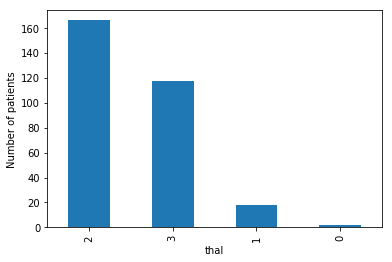

2    166
3    117
1     18
0      2
Name: thal, dtype: int64

In [765]:
heartdisease["thal"].hist()
plt.ylabel("Number of patients")
plt.xlabel("thal")
plt.show()

heartdisease["thal"].value_counts().plot.bar()
plt.ylabel("Number of patients")
plt.xlabel("thal")
plt.show()
heartdisease["thal"].value_counts()

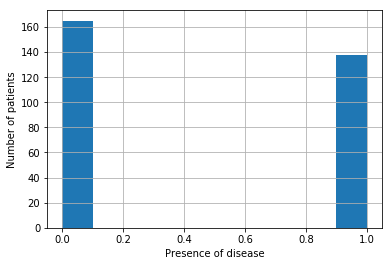

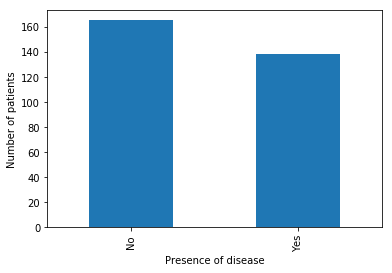

0    165
1    138
Name: sick, dtype: int64

In [766]:
heartdisease["sick"].hist()
plt.ylabel("Number of patients")
plt.xlabel("Presence of disease")
plt.show()

heartdisease["sick"].value_counts().plot.bar()
plt.ylabel("Number of patients")
plt.xlabel("Presence of disease")
plt.xticks([1,0], ["Yes", "No"])
plt.show()
heartdisease["sick"].value_counts()

### Question 1.5 We also want to make sure we are dealing with a balanced dataset. In this case, we want to confirm whether or not we have an equitable number of  sick and healthy individuals to ensure that our classifier will have a sufficiently balanced dataset to adequately classify the two. Plot a histogram specifically of the sick target, and conduct a count of the number of sick and healthy individuals and report on the results: 

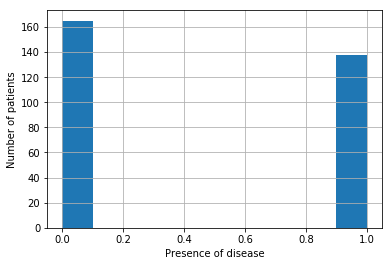

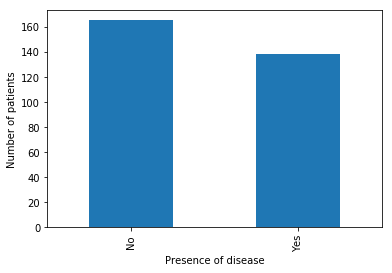

0    165
1    138
Name: sick, dtype: int64

In [767]:
heartdisease["sick"].hist()
plt.ylabel("Number of patients")
plt.xlabel("Presence of disease")
plt.show()

heartdisease["sick"].value_counts().plot.bar()
plt.ylabel("Number of patients")
plt.xlabel("Presence of disease")
plt.xticks([1,0], ["Yes", "No"])
plt.show()
heartdisease["sick"].value_counts()

We do not have an equitable number of sick and healthy individuals. There are 165 healthy individuals and 138 sick individuals, or 54.46% of the samples are healthy and 45.44% of the samples are sick. I don't think that in this case the skew is severe enough to cause bias in the classifier.

### Question  1.6 Balanced datasets are important to ensure that classifiers train adequately and don't overfit, however arbitrary balancing of a dataset might introduce its own issues. Discuss some of the problems that might arise by artificially balancing a dataset.

If we scale down the larger sample, we will disregarded data arbitrarily. It is possible that the dataset loses useful information which might affect how the classifier will be built. Even if the sample is chosen randomly, it could still be biased. Data augmentation of rows could also introduce bias when the distribution of the data is not clear. 

### Question 1.9 Now that we have our dataframe prepared let's start analyzing our data. For this next question let's look at the correlations of our variables to our target value. First, map out the correlations between the values, and then discuss the relationships you observe. Do some research on the variables to understand why they may relate to the observed corellations. Intuitively, why do you think some variables correlate more highly than others (hint: one possible approach you can use the sns heatmap function to map the corr() method)?

cp         -0.433798
thalach    -0.421741
slope      -0.345877
restecg    -0.137230
fbs         0.028046
chol        0.085239
trestbps    0.144931
age         0.225439
sex         0.280937
thal        0.344029
ca          0.391724
oldpeak     0.430696
exang       0.436757
sick        1.000000
Name: sick, dtype: float64

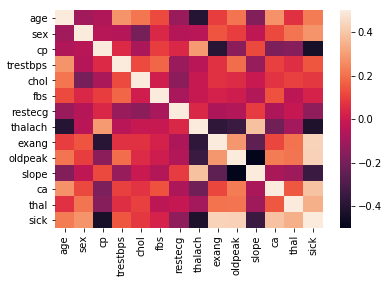

In [768]:
from pandas.plotting import scatter_matrix

corr_matrix_heartdisease = heartdisease.corr()
ax = sns.heatmap(corr_matrix_heartdisease, vmin=-0.5, vmax=0.5)
corr_matrix_heartdisease["sick"].sort_values()

Features that most positively correlated to the presence of disease: 
(showing light color in the heatmap)
- exang: exercise relates to angina because muscles consume oxygen during exercise, causing insufficient oxygen-rick blood flow into the heart. It is reasonable that the presense of heart disease is correlated to the angina induced by exercise. It is one of the most common reasons that could cause heart disease. 
- oldpeak: ST depression is the main indicator of myocardial ischaemia. ST depression is often seen in patients with unstable angina. Therefore, it is reasonable that we see a positive correlation between ST segment depression and the presense of heart disease.
- ca: coloring major vessels by flourosopy is a diagnosis method for heart disease. Most patients with heart disease will have 1-3 vessels colored by flourosopy. Most healthy individuals are supposed to have no vessels colored by flouroscopy. As a method of diagonizing heart disease, it is reasonable that we see a positive correlation between ST segment depression and the presense of heart disease.

Features that most negatively correlated to the presence of disease:
(showing dark color in the heatmap)
- cp: 0 indicates asymptomatic patients while 1-3 indicate angina of different types. The presense of heart disease is negatively related to the chest pain type, indicating that most patients with the disease actually have asymptomatic angina.  
- thalach: Patients with heart disease reach a lower maximum heart rate than those without heart disease. Heart disease weakens the ability of the patient's heart to pump blood as actively as normal people. Therefore, patients with heart disease in general could not reach the maximum heart rate as non-patients.
- slope: Downsloping(0) and flat(1) ST segments indicate the presence of heart disease, while upsloping(1) ST segments indicate that heart disease is not present. 

## [30 Points] Part 2. Prepare the Data 

Before running our various learning methods, we need to do some additional prep to finalize our data. Specifically you'll have to cut the classification target from the data that will be used to classify, and then you'll have to divide the dataset into training and testing cohorts.

Specifically, we're going to ask you to prepare 2 batches of data: 1. Will simply be the raw numeric data that hasn't gone through any additional pre-processing. The other, will be data that you pipeline using your own selected methods. We will then feed both of these datasets into a classifier to showcase just how important this step can be!

### Question 2.1 Save the target column as a separate array and then drop it from the dataframe. 

In [769]:
hd_labels = heartdisease["sick"].copy()
heartdisease = heartdisease.drop("sick", axis=1)

### Question 2.2 First Create your 'Raw' unprocessed training data by dividing your dataframe into training and testing cohorts, with your training cohort consisting of 70% of your total dataframe (hint: use the train_test_split method) Output the resulting shapes of your training and testing samples to confirm that your split was successful.

In [770]:
X_train, X_test, y_train, y_test = train_test_split(heartdisease, hd_labels, test_size=0.3)

In [771]:
X_train = X_train.to_numpy()
X_train.shape

(212, 13)

In [772]:
X_test = X_test.to_numpy()
X_test.shape

(91, 13)

In [773]:
y_train.shape

(212,)

In [774]:
y_test.shape

(91,)

### Question 2.3 Now create a pipeline to conduct any additional preparation of the data you would like. Output the resulting array to ensure it was processed correctly.

In [775]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

numerical_features = ["age", "trestbps", "chol", "thalach", "oldpeak", "ca"]
categorical_features = ["sex", "cp", "restecg", "thal", "slope"]

full_pipeline = ColumnTransformer([
    ("num", StandardScaler(), numerical_features),
    ("cat", OneHotEncoder(), categorical_features)
])

heartdisease_prepared = full_pipeline.fit_transform(heartdisease)
heartdisease_prepared

array([[ 0.9521966 ,  0.76395577, -0.25633371, ...,  1.        ,
         0.        ,  0.        ],
       [-1.91531289, -0.09273778,  0.07219949, ...,  1.        ,
         0.        ,  0.        ],
       [-1.47415758, -0.09273778, -0.81677269, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.50364073,  0.70684287, -1.029353  , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.29046364, -0.09273778, -2.2275329 , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.29046364, -0.09273778, -0.19835726, ...,  0.        ,
         1.        ,  0.        ]])

### Question 2.4 Now create a separate, processed training data set by dividing your processed dataframe into training and testing cohorts, using the same settings as Q2.2 (REMEMBER TO USE DIFFERENT TRAINING AND TESTING VARIABLES SO AS NOT TO OVERWRITE YOUR PREVIOUS DATA). Output the resulting shapes of your training and testing samples to confirm that your split was successful, and describe what differences there are between your two training datasets.

In [776]:
X_train_prep, X_test_prep, y_train_prep, y_test_prep = train_test_split(heartdisease_prepared, hd_labels, test_size=0.3)

In [777]:
X_train_prep.shape

(212, 22)

In [778]:
X_test_prep.shape

(91, 22)

In [779]:
y_train_prep.shape

(212,)

In [780]:
y_test_prep.shape

(91,)

The two datasets are different because the processed datasets are normalized and the categorical features are one-hot-encoded. The features of the resulting datasets are of the same scale, which will increase the accuracy of the classifiers in the following section.

## [50 Points] Part 3. Learning Methods 

We're finally ready to actually begin classifying our data. To do so we'll employ multiple learning methods and compare result.

### Linear Decision Boundary Methods 

### SVM (Support Vector Machine)

A Support Vector Machine (SVM) is a discriminative classifier formally defined by a separating hyperplane. In other words, given labeled training data (supervised learning), the algorithm outputs an optimal hyperplane which categorizes new examples. In two dimentional space this hyperplane is a line dividing a plane in two parts where in each class lay in either side.

### Question 3.1.1 Implement a Support Vector Machine classifier on your RAW dataset. Review the [SVM Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) for how to implement a model. For this implementation you can simply use the default settings, but set probability = True.

In [781]:
# SVM
from sklearn.svm import SVC
clf = SVC(probability=True)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
score = clf.predict_proba(X_test)

### Question 3.1.2 Report the accuracy, precision, recall, F1 Score, and confusion matrix of the resulting model.

Accuracy:    0.648352
Precision:   0.680000
Recall:      0.414634
F1 Score:    0.515152


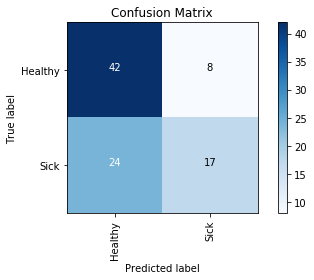

In [782]:
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(y_test, y_predict)))
print("%-12s %f" % ('Precision:', metrics.precision_score(y_test, y_predict)))
print("%-12s %f" % ('Recall:', metrics.recall_score(y_test, y_predict)))
print("%-12s %f" % ('F1 Score:', metrics.f1_score(y_test, y_predict)))
draw_confusion_matrix(y_test, y_predict, ['Healthy', 'Sick'])

### Question 3.1.3 Discuss what each measure is reporting, why they are different, and why are each of these measures is significant. Explore why we might choose to evaluate the performance of differing models differently based on these factors. Try to give some specific examples of scenarios in which you might value one of these measures over the others.

- Accuracy: (true positive + true negative) / (true positive + true negative + false positive + false negative). Accuracy focuses the fraction of correct predictions that we find. In the case of predicting whether a newborn baby is a boy or a girl, we would value the accuracy of the model. Neither predicting a girl as a boy nor predicting a boy as a girl is more acceptable than the other option. 
- Precision: (true positive) / (true positive + false positive). This relates directly to False Positives as a higher precision corresponds to a low rate of false positives. Type I error is when you reject a true null hypothesis, which is by convention false positives. Precision score measures how well the model is resistant from type I error. Precision is important in the case that we want to predict whether a treatment is effective in curing a disease. The null hypothesis is that the medicine does not cure the disease. A low-precision model would predict that the treatment cures the disease while in fact it does not. This would cause delay in diagnosis and treatment of the patient.
- Recall: (true positive) / (true positive + false negative). Recall is the ratio of correctly predicted positive observations to the all observations in actual positive class. Recall score will be higher if we have lower occurrences of false negatives. Type II error is when you accept a false null hypothesis, which is by convention a false negatives. Recall score measures how well our model is resistant from type II error. Recall score is important in testing pregnancy. A null hypothesis is that a person is not pregnant. When a low-recall model predicts a person is not pregnant when she actually is, it would cause serious effects to the body of the patient. When the mother is not aware of her pregnancy and keeps her daily routine, it is possible that an accidental miscarriage would happen. 
- F1 score: (2 * (Recall * Precision) / (Recall + Precision)). F1 score takes into account both false positive and false negative. It is the weighted average of Precision and Recall and therefore takes both false positives and false negatives into account. F1 score is important when the false negatives and false nositives are both crucial. For example, a recommender system is trying to find the relevant products and filter out the irrelevant products. Neither a false positive (an irrelevant product classified as relevant) or a false negative (a relevant product classified as irrelevant) is desirable, and we want to a single score to measure the performance. We would use F1 score in this case.

### Question 3.1.4 Plot a Receiver Operating Characteristic curve, or ROC curve, and describe what it is and what the results indicate

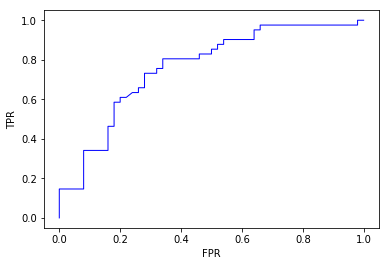

In [783]:
fpr_svm, tpr_svm, thresholds = metrics.roc_curve(y_test, score[:, 1], pos_label=1)
pyplot.figure(1)
pyplot.plot(fpr_svm, tpr_svm, color='blue', lw=1)
pyplot.xlabel('FPR')
pyplot.ylabel('TPR')
pyplot.show()

ROC stands for receiver operating characteristics. ROC curve plots the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The closer the curve is near the top-left corner, the more accurate the test. On the other hand, the closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test. In the plot above, the ROC curve is close to the 45-degree diagonal, indicating that the model is not very accurate. 

### Question 3.1.5 Rerun, using the exact same settings, only this time use your processed data as inputs. 

In [784]:
# SVM
import timeit
start = timeit.default_timer()
from sklearn.svm import SVC
clf = SVC(probability=True)
clf.fit(X_train_prep, y_train_prep)
y_predict_prep = clf.predict(X_test_prep)
score_prep = clf.predict_proba(X_test_prep)
stop = timeit.default_timer()
print('RBF SVM Time: ', stop - start)

RBF SVM Time:  0.01651547197252512


### Question 3.1.6 Report the accuracy, precision, recall, F1 Score, confusion matrix, and plot the ROC Curve of the resulting model.

Accuracy:    0.868132
Precision:   0.868421
Recall:      0.825000
F1 Score:    0.846154


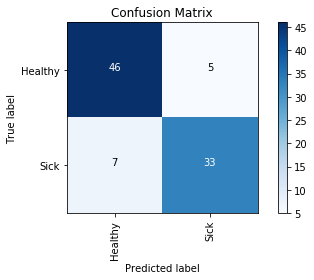

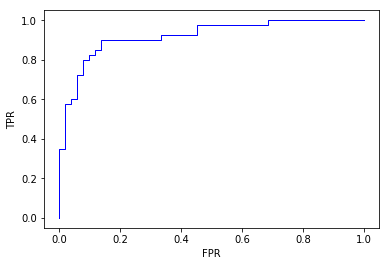

In [785]:
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(y_test_prep, y_predict_prep)))
print("%-12s %f" % ('Precision:', metrics.precision_score(y_test_prep, y_predict_prep)))
print("%-12s %f" % ('Recall:', metrics.recall_score(y_test_prep, y_predict_prep)))
print("%-12s %f" % ('F1 Score:', metrics.f1_score(y_test_prep, y_predict_prep)))
draw_confusion_matrix(y_test_prep, y_predict_prep, ['Healthy', 'Sick'])

fpr_svm, tpr_svm, thresholds = metrics.roc_curve(y_test_prep, score_prep[:, 1], pos_label=1)
pyplot.figure(1)
pyplot.plot(fpr_svm, tpr_svm, color='blue', lw=1)
pyplot.xlabel('FPR')
pyplot.ylabel('TPR')
pyplot.show()

### Question 3.1.7 Hopefully you've noticed a dramatic change in performance. Discuss why you think your new data has had such a dramatic impact. 

The performance has improved dramatically using the processed dataset. During the data processing, we have normalized the numeric features and thereby make the model scale-invariant. We have also one-hot encoded categorical features which are not binary and has concrete non-ordial meanings. The categorical features in the original dataset are already integer-encoded. However, integer encoding might cause the model to learn that there is some ordinal relation between each category while such relation does not exist. After normalization and one-hot-encoding, the accuracy of the model is improved. 

### Question 3.1.8 Rerun your SVM, but now modify your model parameter kernel to equal 'linear'. Again report your Accuracy, Precision, Recall, F1 scores, and Confusion matrix and plot the new ROC curve.  

Linear SVM Time:  0.0067757259821519256
Accuracy:    0.857143
Precision:   0.846154
Recall:      0.825000
F1 Score:    0.835443


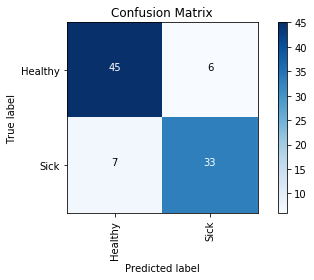

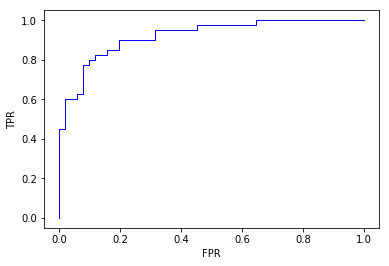

In [786]:
# SVM
start = timeit.default_timer()
clf = SVC(probability=True, kernel='linear')
clf.fit(X_train_prep, y_train_prep)
y_predict_prep = clf.predict(X_test_prep)
score_prep = clf.predict_proba(X_test_prep)
stop = timeit.default_timer()
print('Linear SVM Time: ', stop - start)

print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(y_test_prep, y_predict_prep)))
print("%-12s %f" % ('Precision:', metrics.precision_score(y_test_prep, y_predict_prep)))
print("%-12s %f" % ('Recall:', metrics.recall_score(y_test_prep, y_predict_prep)))
print("%-12s %f" % ('F1 Score:', metrics.f1_score(y_test_prep, y_predict_prep)))
draw_confusion_matrix(y_test_prep, y_predict_prep, ['Healthy', 'Sick'])

fpr_svm, tpr_svm, thresholds = metrics.roc_curve(y_test_prep, score_prep[:, 1], pos_label=1)
pyplot.figure(1)
pyplot.plot(fpr_svm, tpr_svm, color='blue', lw=1)
pyplot.xlabel('FPR')
pyplot.ylabel('TPR')
pyplot.show()

### Question 3.1.9 Explain the what the new results you've achieved mean. Read the documentation to understand what you've changed about your model and explain why changing that input parameter might impact the results in the manner you've observed.

The new model is less accurate as the previous model. I have changed the kernel type from RBF/Gaussian to linear. The kernel function determines the method of finding the hyperplane or decision boundary. A linear SVM is used when the dataset is linearly separable. The advantage of using a linear kernel is that it is less time-consuming, but the accuracy, precision, recall, and f1 score will be lower.

### Logistic Regression

Knowing that we're dealing with a linearly configured dataset, let's now try another classifier that's well known for handling linear models: Logistic Regression. Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable.

### Question 3.2.1 Implement a Logistical Regression Classifier. Review the [Logistical Regression Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for how to implement the model. For this initial model set the solver = 'sag' and max_iter= 10). Report on the same four metrics as the SVM and graph the resulting ROC curve.

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracy:    0.879121
Precision:   0.853659
Recall:      0.875000
F1 Score:    0.864198


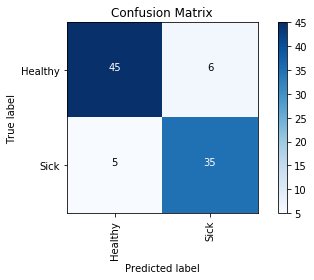

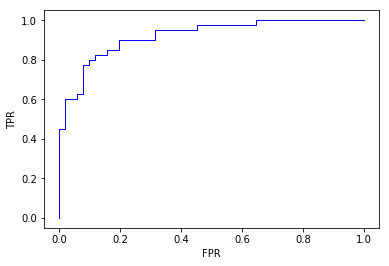

In [787]:
# Logistic Regression
clf = LogisticRegression(solver='sag', max_iter=10).fit(X_train_prep, y_train_prep)
y_predict_prep = clf.predict(X_test_prep)
score = clf.predict_proba(X_test_prep)

print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(y_test_prep, y_predict_prep)))
print("%-12s %f" % ('Precision:', metrics.precision_score(y_test_prep, y_predict_prep)))
print("%-12s %f" % ('Recall:', metrics.recall_score(y_test_prep, y_predict_prep)))
print("%-12s %f" % ('F1 Score:', metrics.f1_score(y_test_prep, y_predict_prep)))
draw_confusion_matrix(y_test_prep, y_predict_prep, ['Healthy', 'Sick'])

fpr_svm, tpr_svm, thresholds = metrics.roc_curve(y_test_prep, score_prep[:, 1], pos_label=1)
pyplot.figure(1)
pyplot.plot(fpr_svm, tpr_svm, color='blue', lw=1)
pyplot.xlabel('FPR')
pyplot.ylabel('TPR')
pyplot.show()

### Question 3.2.2 Did you notice that when you ran the previous model you got the following warning: "ConvergenceWarning: The max_iter was reached which means the coef_ did not converge". Check the documentation and see if you can implement a fix for this problem, and again report your results.

Accuracy:    0.868132
Precision:   0.850000
Recall:      0.850000
F1 Score:    0.850000


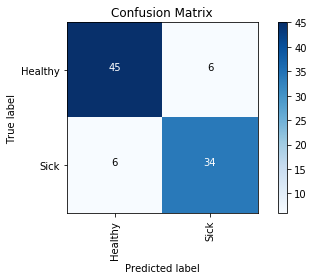

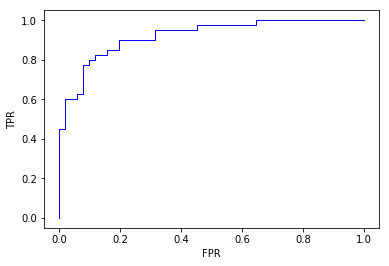

In [788]:
# Logistic Regression
clf = LogisticRegression(solver='sag', max_iter=10000).fit(X_train_prep, y_train_prep)
y_predict_prep = clf.predict(X_test_prep)
score = clf.predict_proba(X_test_prep)

print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(y_test_prep, y_predict_prep)))
print("%-12s %f" % ('Precision:', metrics.precision_score(y_test_prep, y_predict_prep)))
print("%-12s %f" % ('Recall:', metrics.recall_score(y_test_prep, y_predict_prep)))
print("%-12s %f" % ('F1 Score:', metrics.f1_score(y_test_prep, y_predict_prep)))
draw_confusion_matrix(y_test_prep, y_predict_prep, ['Healthy', 'Sick'])

fpr_svm, tpr_svm, thresholds = metrics.roc_curve(y_test_prep, score_prep[:, 1], pos_label=1)
pyplot.figure(1)
pyplot.plot(fpr_svm, tpr_svm, color='blue', lw=1)
pyplot.xlabel('FPR')
pyplot.ylabel('TPR')
pyplot.show()

### Question 3.2.3 Explain what you changed, and why that produced an improved outcome. 

I have increased the maximum number of iterations to 10000. The model will either converge or stop at 10000th iteration when it does not. The previous outcome produces the warning because the value of max_iter is set to a small value. If the dataset is properly normalized and separable (not necessarily linear), logistic regression is likely to converge. If it does not, just increase the maximum number of iterations.

### Question 3.2.4 Rerun your logistic classifier, but modify the penalty = 'none', solver='sag' and again report the results.

Accuracy:    0.857143
Precision:   0.846154
Recall:      0.825000
F1 Score:    0.835443


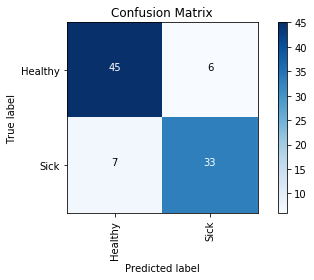

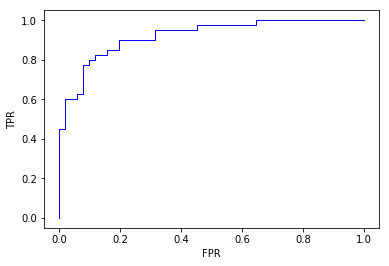

In [789]:
# Logistic Regression
clf = LogisticRegression(solver='sag', max_iter=100000, penalty='none').fit(X_train_prep, y_train_prep)
y_predict_prep = clf.predict(X_test_prep)
score = clf.predict_proba(X_test_prep)

print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(y_test_prep, y_predict_prep)))
print("%-12s %f" % ('Precision:', metrics.precision_score(y_test_prep, y_predict_prep)))
print("%-12s %f" % ('Recall:', metrics.recall_score(y_test_prep, y_predict_prep)))
print("%-12s %f" % ('F1 Score:', metrics.f1_score(y_test_prep, y_predict_prep)))
draw_confusion_matrix(y_test_prep, y_predict_prep, ['Healthy', 'Sick'])

fpr_svm, tpr_svm, thresholds = metrics.roc_curve(y_test_prep, score_prep[:, 1], pos_label=1)
pyplot.figure(1)
pyplot.plot(fpr_svm, tpr_svm, color='blue', lw=1)
pyplot.xlabel('FPR')
pyplot.ylabel('TPR')
pyplot.show()

### Question 3.2.5 Explain what what the penalty parameter is doing in this function, what the solver method is, and why this combination likely produced a more optimal outcome. 

The penalty parameter specifies the way of regularization in the logistic regression model. The default is l2 which adds squared magnitude of coefficient as penalty term to the loss function. The solver method specifies the algorithm to use in the optimization problem. ‘sag’ handles L2 or no penalty and is fast in convergence with larger datasets. The model performs better than the penalty is set to the default value of L2. L2 regularizes the learning rate after each learning step. A larger distance from the true label will result a bigger learning step on the opposite direction. Similarly, if the distance is small, we will adjust the step accordingly. Regularization gives more accurate result and also faster convergence.

### Question 3.2.6 Both logistic regression and linear SVM are trying to classify data points using a linear decision boundary, then what’s the difference between their ways to find this boundary?

SVM tries to find the widest possible separating margin, while Logistic Regression optimizes the log likelihood function, with probabilities modeled by the sigmoid function. 

### Clustering Approaches 

Let us now try a different approach to classification using a clustering algorithm. Specifically, we're going to be using K-Nearest Neighbor, one of the most popular clustering approaches. 

### K-Nearest Neighbor  

### Question 3.3.1 Implement a K-Nearest Neighbor algorithm on our data and report the results. For this initial implementation simply use the default settings. Refer to the [KNN Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) for details on implementation. Report on the accuracy of the resulting model.

In [790]:
# k-Nearest Neighbors algorithm
knn = KNeighborsClassifier()
knn.fit(X_train_prep, y_train_prep)
y_predict_prep = knn.predict(X_test_prep)
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(y_test_prep, y_predict_prep)))

Accuracy:    0.813187


### Question 3.3.2 For clustering algorithms, we use different measures to determine the effectiveness of the model. Specifically here, we're interested in the Homogeneity Score, Completeness Score, V-Measure, Adjusted Rand Score, and Adjusted Mutual Information. Calculate each score (hint review the SKlearn Metrics Clustering documentation for how to implement).

In [791]:
print("%-12s %f" % ('Homogeneity:', metrics.homogeneity_score(y_test_prep, y_predict_prep)))
print("%-12s %f" % ('Completeness:', metrics.completeness_score(y_test_prep, y_predict_prep)))
print("%-12s %f" % ('V-Measure:', metrics.v_measure_score(y_test_prep, y_predict_prep)))
print("%-12s %f" % ('Adjusted Rand Score:', metrics.adjusted_rand_score(y_test_prep, y_predict_prep)))
print("%-12s %f" % ('Adjusted Mutual Information:', metrics.adjusted_mutual_info_score(y_test_prep, y_predict_prep)))

Homogeneity: 0.302012
Completeness: 0.300948
V-Measure:   0.301479
Adjusted Rand Score: 0.385595
Adjusted Mutual Information: 0.295749


### Question 3.3.3 Explain what each score means and interpret the results for this particular model. 

Since KNN is a classification model instead of a clustering algorithm, the scores for measuring clustering algorithms are not meaningful.
- Homogeneity score: a clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class. A lower score means that many points are from different classes in a cluster. 
- Completeness score: completeness measures if all members of a given class are assigned to the same cluster. A low completeness score indicates that members of a given class are assigned to multiple clusters.
- V-Measure: The harmonic mean of homogeneity and completeness is called v-measure score. It takes into account of the homogeneity of each cluster and the consistent cluster labeling of each class. V-measure is symmetric: it can be used to evaluate the agreement of two independent assignments on the same dataset. Random labeling won’t yield zero scores especially when the number of clusters is large.
- Adjusted Rand Score: the Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings. ARI = (RI - Expected_RI) / (max(RI) - Expected_RI). For smaller sample sizes or larger number of clusters it is safer to use an adjusted index such as the Adjusted Rand Index (ARI).
- Adjusted Mutual Information: mutual information score is a measure of mutual dependence between two clusetrings of the same data. It quantifies the amount of information obtained about one clustering through observing the other one. Adjusted mutual information accounts for the fact that the MI is generally higher for two clusterings with a larger number of clusters, regardless of whether there is actually more information shared, so adjusted mutual information is cluster-size-invariant. 

As we're beginning to see, the input parameters for your model can dramatically impact the performance of the model. How do you know which settings to choose? Studying the models and studying your datasets are critical as they can help you anticipate which models and settings are likely to produce optimal results. However sometimes that isn't enough, and a brute force method is necessary to determine which parameters to use. For this next question we'll attempt to optimize a parameter using a brute force approach. 

### Question 3.3.4 Parameter Optimization.  The KNN Algorithm includes an n_neighbors attribute that specifies how many neighbors to use when developing the cluster. (The default value is 5, which is what your previous model used.) Lets now try n values of: 1, 2, 3, 5, 10, 20, 50, and 100. Run your model for each value and report the 6 measures (5 clustering specific plus accuracy) for each. Report on which n value produces the best accuracy and V-Measure. (HINT leverage python's ability to loop to run through the array and generate results without needing to manually code each iteration).

In [792]:
max_accur = 0
max_n = -1
for i in [1,2,3,5,10,20,50]:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_prep, y_train_prep)
    y_predict_prep = knn.predict(X_test_prep)
    curr_accur = metrics.accuracy_score(y_test_prep, y_predict_prep)
    if curr_accur > max_accur:
        max_accur = curr_accur
        max_n = i
    print("n =",i)
    print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(y_test_prep, y_predict_prep)))
    print("%-12s %f" % ('Homogeneity:', metrics.homogeneity_score(y_test_prep, y_predict_prep)))
    print("%-12s %f" % ('Completeness:', metrics.completeness_score(y_test_prep, y_predict_prep)))
    print("%-12s %f" % ('V-Measure:', metrics.v_measure_score(y_test_prep, y_predict_prep)))
    print("%-12s %f" % ('Adjusted Rand Score:', metrics.adjusted_rand_score(y_test_prep, y_predict_prep)))
    print("%-12s %f" % ('Adjusted Mutual Information:', metrics.adjusted_mutual_info_score(y_test_prep, y_predict_prep)))
    
print ("\nThe model with the best performance: ", max_n)

n = 1
Accuracy:    0.802198
Homogeneity: 0.281205
Completeness: 0.279428
V-Measure:   0.280314
Adjusted Rand Score: 0.358254
Adjusted Mutual Information: 0.274419
n = 2
Accuracy:    0.780220
Homogeneity: 0.232614
Completeness: 0.241401
V-Measure:   0.236926
Adjusted Rand Score: 0.306335
Adjusted Mutual Information: 0.230529
n = 3
Accuracy:    0.769231
Homogeneity: 0.232424
Completeness: 0.230148
V-Measure:   0.231280
Adjusted Rand Score: 0.282078
Adjusted Mutual Information: 0.224996
n = 5
Accuracy:    0.813187
Homogeneity: 0.302012
Completeness: 0.300948
V-Measure:   0.301479
Adjusted Rand Score: 0.385595
Adjusted Mutual Information: 0.295749
n = 10
Accuracy:    0.857143
Homogeneity: 0.402253
Completeness: 0.408344
V-Measure:   0.405276
Adjusted Rand Score: 0.504718
Adjusted Mutual Information: 0.400348
n = 20
Accuracy:    0.802198
Homogeneity: 0.277479
Completeness: 0.277479
V-Measure:   0.277479
Adjusted Rand Score: 0.358233
Adjusted Mutual Information: 0.271540
n = 50
Accuracy:    

### Question 3.3.5 When are clustering algorithms most effective, and what do you think explains the comparative results we achieved?  

The clustering algorithms are a method of unsupervised learning, that is the dataset given to the model training does not include labels.  Unsupervised learning aims to discover hidden patterns in data. We should use clustering algorithms when we only want to investigate the structure of the data by grouping the data points into distinct subgroups. We don’t evaluate a clustering model by compareing the output of the clustering algorithm to the true labels to evaluate its performance; instead, we look at if each cluster is homogeneous in its composition and if each subclass is categorized to the same cluster.